# Twitter data analytics

In [1045]:
# Import modules
import requests
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings



In [488]:
# define parameters
raw_data = "twitter_raw_data.csv"
processed_data = "twitter_processed_data.csv"
sns.set_style(style = 'darkgrid')

# 1. Pulling data from Twitter using tweepy

In [490]:
# Overview of twitter data fields I have tested/experimented/explored with
# info here used in determining which fields to pull and use

# Tweet objects:
#     text - (tweet text)
#     attachments - (media_key to join media object)
#     author_id - (author_id to join user object)
#     context_annotations - (domain and entity pairs, (with id, name and description) - hard to use for project (text based analytics required))
#     created_at - tweet created datetime
#     public_metrics - (RT, reply, like, quote counts)
#     conversation_id - (key for..)
#     entities - (info on position and value of: url, hashtags, symbols, user_mentions, polls, media in tweet)
#     geo - (cant really use with essential access)
#     id - (tweet id)
#     in_reply_to_user_id - (id of user tweet is in reply to)
#     lang - (language)
#     referenced_tweets - (type,id of original tweet -e.g. if a retweet)
#     reply_settings - (who can reply)
#     source - (how accessed twitter, e.g. twitter for android)
#     withheld - (withheld information, not very helpful)
#     others - (not available or not useful with essential access)

# User objects:
#     id - (user id)
#     created_at - (datetime profile created)
#     description - (profile bio text)
#     entities - (info on position and value of: url, hashtags, symbols, user_mentions, media in description bio)
#     location - (place user created profile) frequently null or wrong
#     pinned_tweet_id - (tweet id of pinned tweet)
#     profile_image_url - (url of profile pic)
#     protected - (if user is private or not - should always be False for me (No following))
#     public_metrics - (followers_count, following_count, tweet_count, listed_count)
#     url - (url in bio)
#     username - (username)
#     verified - (is user if verified as that person or not (think this is for big public figures only))
#     withheld - (withheld information) 
    
# Media objects:
#     type - (type of media e.g. video/pic)
#     height
#     width
#     duration_ms - (ms duration, only for video)
#     public_metrics - (view count, only for video)
#     preview_image_url - (image url)
#     #the below three need user authentication
#     non_public_metrics - (playback times/quartiled)
#     organic_metrics - (playback times/quartiled tracked on organic basis)
#     promoted_metrics - (playback times/quartiled on promoted basis)
    
# Space objects: (live streaming objects, not available after ended) - not useful for this project
# Poll objects: not useful for this project
# Place objects: (most of the other info to do with place is unavailable/hard to use with essential access)

In [521]:
# Get all accessible data deemed appropriate
APP_ID = "22591708"
App_name = "alexanderfarqu2"
API_key = "ON4SJ0U3Sb0ODjUk6ZquERxiv"
API_key_secret = "g5JoHVL4uxCoFXLvEYTSojaEBPODyYmiI0bMeuvHYQt5JsyVE6"
bearer_token = "AAAAAAAAAAAAAAAAAAAAANy4WAEAAAAAlTukwlSz2gZnDi9xKeo3lp471qM%3DxU6od5cFrnKdcLHZHXx2I6cp99WT6QnKOpirCWfm75U42yXth2"
access_token = "1463912691429527556-rZ1rFU6GgR3a4xYcWdTbvsomCn5shl"
access_token_secret = "qqU34qYcJ0B8iEZC82DZ6OZqzrYy8IBJ51UGNsLdXvKZh"

client = tweepy.Client(bearer_token = bearer_token)

In [529]:
# query data (through trial and error of testing what tweets I want)
'''
querying notes:
    default is and logic (otherwise put or between words)
    some useful filters: is:, has:, lang: (not all available with essential access like place_country:)
        e.g. is:retweet lang:en has:images
    - negates anything:
        e.g. -snow -is:nullcast
    group and/or logic with brackets:
        e.g. (a b) or (c has:images)
'''

query = '(tennis lang:en -is:retweet)' #has:media remove as not enough tweets

In [530]:
# tweet fields chosen from above
tweet_fields=['attachments', 'author_id', 'created_at', 'public_metrics', 'conversation_id', 'entities', 'geo', 'id', 'in_reply_to_user_id','lang', 'referenced_tweets','reply_settings','source']

In [531]:
# just using expansions to get additional media and author info
expansions = ['author_id', 'attachments.media_keys']

In [532]:
# user fields chosen from above
user_fields = ['created_at','entities','id','profile_image_url','public_metrics','username','verified']

In [533]:
# user fields chosen from above
media_fields = ['height','width','public_metrics']

In [535]:
# extract data (not flattening as that would loose expansions data)
# 50000 is around the limit I can pull in one query
tweets = []
expan = []
for tweet in tweepy.Paginator(client.search_recent_tweets,
                          query=query, 
                          tweet_fields = tweet_fields, 
                          user_fields = user_fields, 
                          max_results = 100, 
                          expansions = expansions,
                          limit=500):
    tweets.append(tweet[0])
    try:
        expan.append(tweet[1])
    except:
        pass

In [536]:
# 1 dimensionalise tweets data
tweets = [tweet for sub in tweets for tweet in sub]

In [537]:
# extract user information
users = []
for el in expan:
    users.append(el['users'])
    
# flatten
users = [user for sub in users for user in sub]    

In [538]:
# extract media information
medias = []
for el in expan:
    medias.append(el['media'])
    
# flatten
medias = [media for sub in medias for media in sub]    

In [539]:
for x in (tweets, users, medias):
    print(len(x))

44850
41679
9269


In [540]:
# create tweet_df
tweet_df = pd.DataFrame()
# keys
tweet_df['author_id']= [tweet.author_id for tweet in tweets]
tweet_df['tweet_id']= [tweet.id for tweet in tweets]
tweet_df['attachments']= [tweet.attachments for tweet in tweets]
tweet_df['in_reply_to_user_id']= [tweet.in_reply_to_user_id for tweet in tweets] #drop?
tweet_df['referenced_tweets']= [tweet.referenced_tweets for tweet in tweets] #drop?

# cat variables
tweet_df['text']= [tweet.text for tweet in tweets]
tweet_df['lang']= [tweet.lang for tweet in tweets]
tweet_df['source']= [tweet.source for tweet in tweets]
tweet_df['reply_settings']= [tweet.reply_settings for tweet in tweets] # drop?
tweet_df['entities']= [tweet.entities for tweet in tweets]


# num variables
tweet_df['ret_count']= [tweet.public_metrics['retweet_count'] for tweet in tweets]
tweet_df['reply_count']= [tweet.public_metrics['reply_count']for tweet in tweets]
tweet_df['like_count']= [tweet.public_metrics['like_count']for tweet in tweets]
tweet_df['quote_count']= [tweet.public_metrics['quote_count']for tweet in tweets]

#date variables
tweet_df['created_at']= [tweet.created_at for tweet in tweets]

In [542]:
# get first media_key only from attachments column. Set to 0 if missing
x = {'media_keys':[0]}
tweet_df['attachments'] = np.where(~tweet_df['attachments'].isna(),tweet_df['attachments'],x)
# assure none missing
tweet_df['attachments'].isna().sum()

0

In [543]:
media_keys = []
for el in tweet_df['attachments']:
    for v in el.values():
        media_keys.append(v[0])
        
tweet_df['media_key'] = media_keys
tweet_df.drop(['attachments'], inplace = True, axis = 1)

In [545]:
# create users_df
users_df = pd.DataFrame()
# keys
users_df['author_id']= [user.id for user in users]

# num vars
users_df['profile_created_at']= [user.created_at for user in users]
users_df['followers_count']= [user.public_metrics['followers_count'] for user in users]
users_df['following_count']= [user.public_metrics['following_count'] for user in users]
users_df['user_tweet_count']= [user.public_metrics['tweet_count'] for user in users]

# cat vars
users_df['profile_entities']= [user.entities for user in users]
users_df['username']= [user.username for user in users]
users_df['verified']= [user.verified for user in users]

# deduplicated (could have multiple tweets by same person in search but at differnt point - ensure when join, not multiple rows for same tweet)
users_df = users_df[users_df['author_id'].duplicated() == False]

In [546]:
# create media_df
media_df = pd.DataFrame()
# keys
media_df['media_key']= [media.media_key for media in medias]

# cat vars
media_df['media_type']= [media.type for media in medias]

#deduplicate (precautionary measure - theoretically none should be removed)
media_df = media_df[media_df['media_key'].duplicated() == False]

In [547]:
# join data frames on relevant keys
master_df = tweet_df.merge(right = users_df, how = 'left', on = 'author_id').merge(right = media_df, how = 'left', on = 'media_key')
# master_df_copy = master_df.copy()

In [548]:
# save raw dataframe
master_df.to_csv(raw_data, index = False)

# 2. Data preprocessing
## 2.1 Preliminary data checks and filtering

In [1092]:
# load raw df
master_df = pd.read_csv(raw_data, parse_dates = ['created_at','profile_created_at'])

In [1093]:
# should be same length as tweet_df
print(master_df.shape, tweet_df.shape)

(44850, 23) (44850, 15)


Good - is same length as tweet_df (no dupes)

In [1094]:
# ensure no tweets are a RT
print(master_df[master_df['text'].str.startswith('RT')].shape)
# remove retweets
master_df = master_df[~master_df['text'].str.startswith('RT')]

(20, 23)


Enure no retweets in sample

In [1095]:
# ensure all have same value for reply_settings, (needed to be fair when looking at visibility metrics)
print(master_df['reply_settings'].value_counts())
master_df = master_df[master_df['reply_settings'] =='everyone']

everyone          44624
following           111
mentionedUsers       95
Name: reply_settings, dtype: int64


Removed ~200 rows

In [1096]:
master_df.columns

Index(['author_id', 'tweet_id', 'in_reply_to_user_id', 'referenced_tweets',
       'text', 'lang', 'source', 'reply_settings', 'entities', 'ret_count',
       'reply_count', 'like_count', 'quote_count', 'created_at', 'media_key',
       'profile_created_at', 'followers_count', 'following_count',
       'user_tweet_count', 'profile_entities', 'username', 'verified',
       'media_type'],
      dtype='object')

In [1097]:
# Get list of cols to drop - determine which ones may not be needed for analysis
# metrics:
#     if referenced a tweet
#     if in reply to a tweet
#     tweet text
#     tweet language
#     tweet app source
#     reply_settings
#     entities - (use if hashtag)
#     num retweets, replies, likes, quotes
#     when_created
#     when profile_created
#     profile_entities - if hashtag
#     followers, following, no. tweets count
#     verified
#     media type (if any)

In [1098]:
cols_to_drop = ['in_reply_to_user_id','referenced_tweets','text','lang','username','reply_settings']
master_df.drop(cols_to_drop, axis = 1, inplace = True)
# list of remaining columns
master_df.columns

Index(['author_id', 'tweet_id', 'source', 'entities', 'ret_count',
       'reply_count', 'like_count', 'quote_count', 'created_at', 'media_key',
       'profile_created_at', 'followers_count', 'following_count',
       'user_tweet_count', 'profile_entities', 'verified', 'media_type'],
      dtype='object')

In [1099]:
# Filtering outliers
num_stats = master_df.drop(['author_id','tweet_id'],axis=1).describe()
num_stats

,ret_count,reply_count,like_count,quote_count,followers_count,following_count,user_tweet_count
count,44624.000000,44624.000000,44624.000000,44624.000000,4.462400e+04,44624.000000,4.462400e+04
mean,1.839974,0.737899,12.588159,0.201282,2.462324e+04,1256.467596,5.529016e+04
std,137.725204,7.463816,719.720908,6.748776,5.250473e+05,5150.710178,1.803147e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,6.600000e+01,101.000000,2.234000e+03
50%,0.000000,0.000000,0.000000,0.000000,3.670000e+02,389.000000,1.059200e+04
75%,0.000000,1.000000,2.000000,0.000000,1.515250e+03,1065.250000,4.119025e+04
max,28382.000000,1053.000000,146812.000000,1276.000000,5.577544e+07,370881.000000,3.659432e+06


In [1100]:
# Remove outlier rows with extremely high values ()
print(master_df.shape[0], ': cols before filtering')
for var in list(num_stats.columns):
    outlier_min = num_stats[var]['mean'] + 10*num_stats[var]['std']
    master_df = master_df[master_df[var] <= outlier_min]
    
print(master_df.shape[0], ': cols after filtering')

44624 : cols before filtering
44352 : cols after filtering


## 2.2 Column manipulation processing

In [1101]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44352 entries, 0 to 44849
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   author_id           44352 non-null  int64              
 1   tweet_id            44352 non-null  int64              
 2   source              44352 non-null  object             
 3   entities            40227 non-null  object             
 4   ret_count           44352 non-null  int64              
 5   reply_count         44352 non-null  int64              
 6   like_count          44352 non-null  int64              
 7   quote_count         44352 non-null  int64              
 8   created_at          44352 non-null  datetime64[ns, UTC]
 9   media_key           44352 non-null  object             
 10  profile_created_at  44352 non-null  datetime64[ns, UTC]
 11  followers_count     44352 non-null  int64              
 12  following_count     44352 non-nu

In [1102]:
# Combine keys for ease and drop originals
master_df['tweet_id'] = master_df['tweet_id'].astype(str)
master_df['author_id'] = master_df['author_id'].astype(str)
master_df['media_key'] = master_df['media_key'].astype(str)
master_df['id'] = master_df['tweet_id'] + "-" + master_df['author_id']  + "-" + master_df['media_key']
keys = ['media_key', 'author_id', 'tweet_id']
master_df.drop(keys, inplace = True, axis = 1)

# reset index to something meaningful
master_df.set_index('id', inplace = True)

In [1103]:
# categorise boolean verified column
print(master_df['verified'].value_counts())
master_df['verified'] = pd.get_dummies(master_df['verified'], drop_first = True)
master_df['verified'] = master_df['verified'].astype(str)
print(master_df['verified'].value_counts())

False    42339
True      2013
Name: verified, dtype: int64
0    42339
1     2013
Name: verified, dtype: int64


Verified can be used as an explanatory variable - need to put into integer format for data analysis

In [1104]:
# source variable
print(master_df['source'].value_counts()[:10])

Twitter for iPhone         14095
Twitter for Android         9125
Twitter Web App             8796
WordPress.com               1744
dlvr.it                     1509
Twitter for iPad            1357
TweetDeck                   1022
Twitter                      777
Cheap Bots, Done Quick!      665
IFTTT                        357
Name: source, dtype: int64


group source values if not in top 3 known values

In [1105]:
sources = ['Twitter for Android','Twitter for iPhone','Twitter Web App']
master_df['source'] = np.where(master_df['source'].apply(lambda x: x in sources), master_df['source'], 'other')
print(master_df['source'].value_counts())

Twitter for iPhone     14095
other                  12336
Twitter for Android     9125
Twitter Web App         8796
Name: source, dtype: int64


A form of rare level grouping into 4 groups for ease of analysis

In [1106]:
# get profile and tweet hashtag flags from entities and drop entities columns
master_df['profile_entities'] = master_df['profile_entities'].astype(str)
master_df['entities'] = master_df['entities'].astype(str)

master_df['profile_ht'] = np.where(master_df['profile_entities'].str.contains('hashtags'),"1","0")
master_df['tweet_ht'] = np.where(master_df['entities'].str.contains('hashtags'),"1","0")

master_df.drop(['profile_entities','entities'], axis = 1, inplace = True)

In [1107]:
# time columns

# get tweet age in minutes
import pytz #needed to set a timezone value to UTC (to make comptabile with current date columns)
import datetime
master_df['today_date'] = datetime.datetime.now(tz = pytz.UTC)
master_df['tweet_age_mins'] =  master_df['today_date'] - master_df['created_at']
master_df['tweet_age_mins'] = master_df['tweet_age_mins'].apply(lambda x: x.seconds//60)

In [1108]:
# create time from profile created to tweet created in days
master_df['profile_tweet_diff'] = master_df['created_at']  - master_df['profile_created_at']
master_df['profile_tweet_diff'] = master_df['profile_tweet_diff'].apply(lambda x: x.days)

In [1109]:
# drop now unneeded time columns
master_df.drop(['created_at','profile_created_at','today_date'], axis = 1, inplace = True)

In [1110]:
# view if any column has missings
for x in num_vars + cat_vars:
    print(x, master_df[x].isna().any())

ret_count False
reply_count False
like_count False
quote_count False
followers_count False
following_count False
user_tweet_count False
tweet_age_mins False
profile_tweet_diff False
source False
verified False
media_type True
profile_ht False
tweet_ht False


Deal with media_type missings - this will be because no media in tweet (text)

In [1111]:
master_df['media_type'] = np.where(~master_df['media_type'].isna(), master_df['media_type'], 'None')
master_df['media_type'].value_counts(dropna=False)

None            36736
photo            6280
animated_gif      692
video             644
Name: media_type, dtype: int64

In [1112]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44352 entries, 1478348463746138112-872997918-0 to 1475813536421105666-1466025361716781060-3_1475813505270005768
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              44352 non-null  object
 1   ret_count           44352 non-null  int64 
 2   reply_count         44352 non-null  int64 
 3   like_count          44352 non-null  int64 
 4   quote_count         44352 non-null  int64 
 5   followers_count     44352 non-null  int64 
 6   following_count     44352 non-null  int64 
 7   user_tweet_count    44352 non-null  int64 
 8   verified            44352 non-null  object
 9   media_type          44352 non-null  object
 10  profile_ht          44352 non-null  object
 11  tweet_ht            44352 non-null  object
 12  tweet_age_mins      44352 non-null  int64 
 13  profile_tweet_diff  44352 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 

all variables are in appropriate formats, no nulls

# 3. Data exploration

## 3.1 General

In [1113]:
cat_vars = ['source', 'verified','media_type','profile_ht','tweet_ht']
num_vars = ['ret_count', 'reply_count','like_count','quote_count','followers_count','following_count','user_tweet_count','tweet_age_mins','profile_tweet_diff']

### Categorical vars

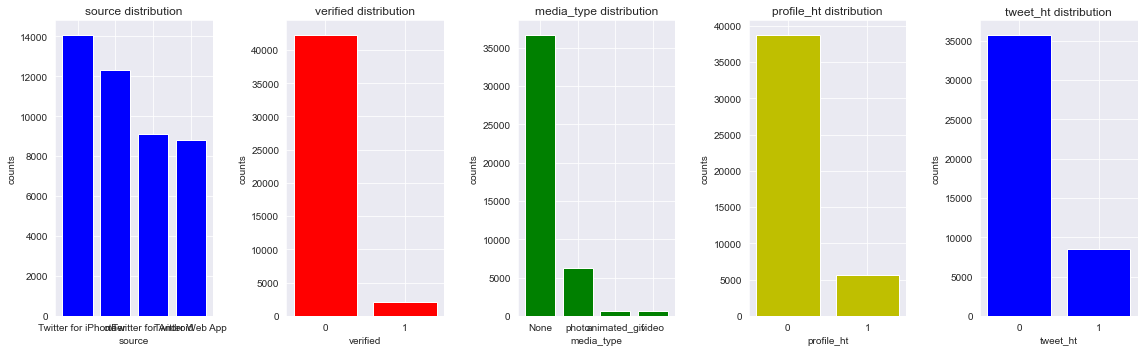

In [1114]:
# plot bar chart for each cat variable
y=0
colours = ['b','r','g','y','b']
fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (16,5), squeeze = False)
    
for var in cat_vars:
    counts = list(master_df[var].value_counts().values)
    items = list(master_df[var].value_counts().index)
    xs = range(len(items))

    axes[0,y].bar(items,counts, color = colours[y])
    axes[0,y].set(title = f'{var} distribution', xlabel = var, ylabel = 'counts')
#    rotating messes things up..
#     axes[0,y].set_xticklabels(items, Rotation = 60)
    y+=1;
fig.tight_layout()

* Far fewer people verified than not (whats the requirement to qualify for even being verified - no. of followers?
* Media: None > Photos > vieos and gifs 
* Slightly more people hashtag in their tweets than in their profile bio, in general people dont use #
* All categorical groupings are large enough for meaningful analysis (bar video and gifs)

# Numerical variables

In [1115]:
master_df[num_vars].describe()

,ret_count,reply_count,like_count,quote_count,followers_count,following_count,user_tweet_count,tweet_age_mins,profile_tweet_diff
count,44352.000000,44352.000000,44352.000000,44352.000000,4.435200e+04,44352.000000,4.435200e+04,44352.000000,44352.000000
mean,0.740124,0.591180,6.213226,0.115508,1.405269e+04,1057.224499,4.830640e+04,685.749594,2154.235390
std,8.853680,2.351481,59.949418,1.109780,1.409304e+05,2393.644625,1.358010e+05,425.215428,1643.266052
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,6.600000e+01,101.000000,2.206000e+03,330.000000,528.000000
50%,0.000000,0.000000,0.000000,0.000000,3.605000e+02,385.000000,1.044350e+04,620.000000,1964.000000
75%,0.000000,1.000000,2.000000,0.000000,1.471250e+03,1050.000000,4.024600e+04,1076.000000,3700.000000
max,796.000000,75.000000,4128.000000,65.000000,5.145740e+06,51952.000000,1.850505e+06,1439.000000,5633.000000


* Ret_count, reply_count, like_count, quote_count: Mostly 0s. Heavy right skew
* followers_count: mode > mean, so slight left skew, but clearly some abnormal author(s) with 55 million + followers
* user_tweet_count: mode > mean, so slight left skew, but clearly some abnormal author(s) with >1 million tweets (bots?)

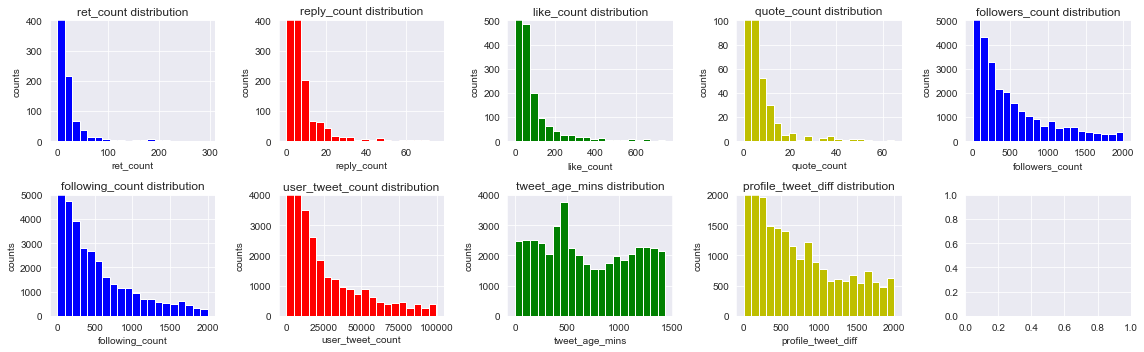

In [1121]:
# plot hist plot for each num variable

# temporarily filter out rows with exceptionally high values otherwise graphs wont be helpful
num_var_max = [300,100,750,100,2000,2000,100000,2000,2000]
# similarly, set ylims individually otherwise non-meaningful graphs
y_lims = [400,400,500,100,5000,5000,4000,4000,2000]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize = (16,5), squeeze = False)
ax_list =[(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3)]
colours = ['b','r','g','y','b']
y = 0

for var in num_vars:
    temp_df = master_df[(master_df[var]<num_var_max[y])]
    axes[ax_list[y]].hist(temp_df[var], bins = 20, color = colours[ax_list[y][1]]);
    axes[ax_list[y]].set_ylim(0,y_lims[y])
    axes[ax_list[y]].set(title = f'{var} distribution', xlabel = var, ylabel = 'counts') 
    y+=1
fig.tight_layout();

* Ret_count, reply_count, like_count, quote_count: high proportion have <= 1. Fast decay from 0.
* followeing_count, followers_count: distribution similar. Slower decay from 0.
* tweet_count: potentially bot users for tweets more than 1Million
* tweet_age: fairly uniform, peak at 100 mins ago (taken at 11 am UK, so peak at ~11 am UTC or ~8pm HongKong time, 5pm New Delhi time)
* profile_tweet_diff: decreases with time (expected, more active users (as our sample is only tweets in last 7 days) are more new)

In [1125]:
# Correlation for num variables (bring in the cat variables so we can see all correlations)
corr_df = master_df.copy()

corr_df['source Twitter Web App'] = pd.get_dummies(corr_df['source'])['Twitter Web App']
corr_df['source Twitter for Android'] = pd.get_dummies(corr_df['source'])['Twitter for Android']
corr_df['source Twitter for iPhone'] = pd.get_dummies(corr_df['source'])['Twitter for iPhone']
corr_df['source other'] = pd.get_dummies(corr_df['source'])['other']

corr_df['media_type None'] = pd.get_dummies(corr_df['media_type'])['None']
corr_df['media_type animated_gif'] = pd.get_dummies(corr_df['media_type'])['animated_gif']
corr_df['media_type photo'] = pd.get_dummies(corr_df['media_type'])['photo']
corr_df['media_type video'] = pd.get_dummies(corr_df['media_type'])['video']

corr_df['verified'] = corr_df['verified'].astype(int)
corr_df['profile_ht'] = corr_df['profile_ht'].astype(int)
corr_df['tweet_ht'] = corr_df['tweet_ht'].astype(int)

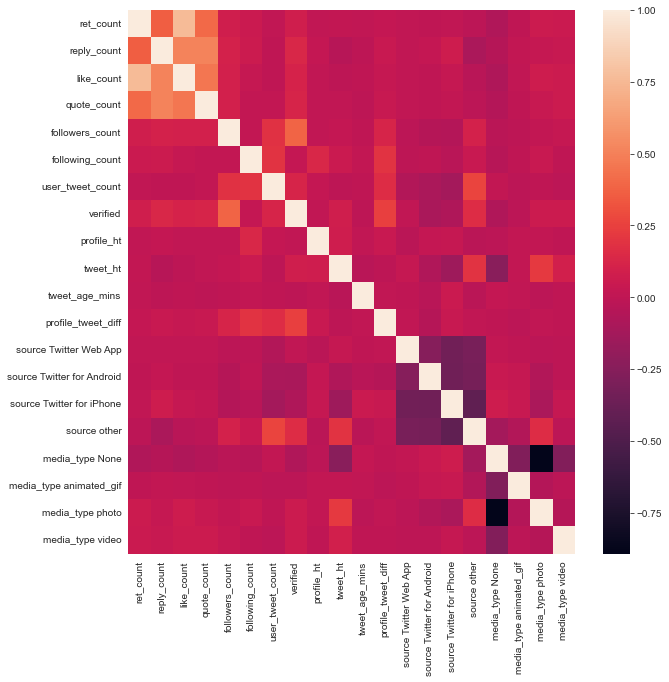

In [1126]:
corr_df = corr_df.corr()
plt.subplots(figsize = (10,10))
sns.heatmap(corr_df);

* All public tweet metrics (ret_count reply_count like_count quote_count) are highly correlated (can remove all but one?).
* user_tweet_count, follower_count, profile_tweet_diff and verified are all somewhat correlated.
* media_type: interestingly photo has a slight correlation with tweet_ht (otherwise no correlations).
* source: interestingly other has a greater correlation with verified and tweet_ht than other sources.

# 4 Questions:

## 4.1 How to get the most favourable tweets?
* Assume ret_count reply_count like_count quote_count are good predictors of tweet favourability
* due to high correlation of these metrics, can chooose just one as a proxy to look at: choose "like_count".
* likely explanatory variables that may influence tweet favourability:
    * cat: source, verified, media_type, tweet_ht
    * num: no followers, tweet_age_mins

In [1128]:
# 2 way distribution
# scatter plot of followers_count and like_count unhelpful, as hard to show any correlation with so many data point having 0 likes etc.
#instead, band the numerical variables and plot them similarly to categorical variables
master_df['followers_count_banded'] =  pd.qcut(master_df['followers_count'],5, labels = [1,2,3,4,5])
# master_df2['followers_count_banded']= master_df2['followers_count_banded'].astype(str)
master_df['tweet_age_mins_banded'] =  pd.qcut(master_df['tweet_age_mins'],5, labels = [1,2,3,4,5])
master_df['tweet_age_mins_banded'] = master_df['tweet_age_mins_banded'].astype(str)

master_df['verified'] = master_df['verified'].astype(str)
master_df['tweet_ht'] = master_df['tweet_ht'].astype(str)

N.B. Followers count banded and tweet age mins banded groups contain 20% of rows ordered by Followers_count increasing and tweet age mins increasing respectively


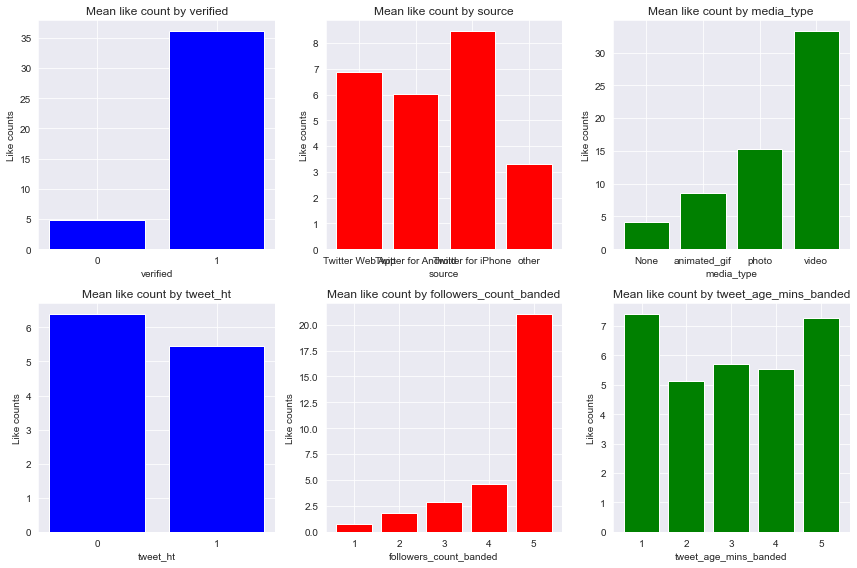

In [1131]:
# Visualising how variables affect a tweets like count with bar charts
print('N.B. Followers count banded and tweet age mins banded groups contain 20% of rows ordered by Followers_count increasing and tweet age mins increasing respectively')
y=0
ax_list =[(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
colours = ['b','r','g']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (12,8), squeeze = False)
vars_list = ['verified', 'source', 'media_type', 'tweet_ht','followers_count_banded','tweet_age_mins_banded']
for var in vars_list:

    items = list(master_df[['like_count',var]].groupby(var).mean()['like_count'].index)
    mean_likes = list(master_df[['like_count',var]].groupby(var).mean()['like_count'].values)
    axes[ax_list[y]].bar(items, mean_likes, color = colours[ax_list[y][1]])
    axes[ax_list[y]].set(title = f'Mean like count by {var}', xlabel = var, ylabel = 'Like counts')
    
#     rotating messes up the labels for some reason..
#     axes[ax_list[y]].set_xticklabels(items, Rotation = 5)
    y+=1;
fig.tight_layout()

* Of categorical variables, using like_count as proxy for favourability:
    * verified is best way to get greater favourability
        * But verified is correlated with number followers and auther tweet count! - Determine which is driving favourability up
    * Source: other, has greatest favourability, we saw earlier the correlation with verified, which is likely the reason for this
    * Having video or gif in tweet helps favourability - (seen earlier no correlations with any variables that determine favourability) - so can say that this correlation is genuine.
    * having a # in tweet interestingly doesn't increase favourability!
    * having more followers increases favourability: logically this is liekly the reason for greater favourability rather than verified flag (tbc later)
    * tweets with time in lower two quartiles have slightly lower favourability than those in higher

## 4.2 What is verified status, and does it help your visibility?:
* Twitter defines verified as: Notable (represent prominent brand or figure), Authentic (documents to proove authenticity) and Active:
* But what does it mean in terms of twitter based metrics to be verified?
* Does verifiability actually help your visibility?

In [1132]:
master_df['verified'].value_counts()

0    42339
1     2013
Name: verified, dtype: int64

2000 verified users sample size

In [1134]:
mini = master_df[master_df['verified']=='1'][num_vars].min()
maxi = master_df[master_df['verified']=='1'][num_vars].max()
stats_df = pd.DataFrame(mini, index = num_vars, columns=['minimum'])
stats_df['maximum'] = maxi
stats_df

,minimum,maximum
ret_count,0,796
reply_count,0,75
like_count,0,4056
quote_count,0,65
followers_count,124,5145740
following_count,0,31864
user_tweet_count,30,1496104
tweet_age_mins,0,1438
profile_tweet_diff,77,5454


C:\Users\farqu\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


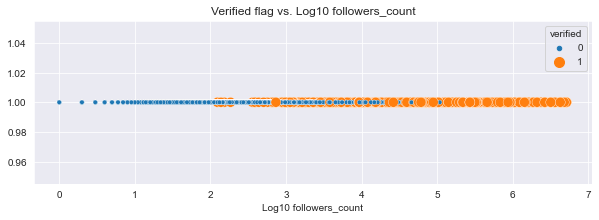

In [1135]:
fig,ax = plt.subplots(figsize = (10,3))
sns.scatterplot(x=np.log10(master_df['followers_count']),y=1,
                hue = master_df['verified'],
                size = master_df['verified'], sizes = (100,20))

ax.set(title = f'Verified flag vs. Log10 followers_count', xlabel = 'Log10 followers_count');

* All authors with > ~1Million followers are verified
* All verified accounts have non zero followers_count and tweet_count.
* Conclusion: No obvious cutoff here to be a verified users.

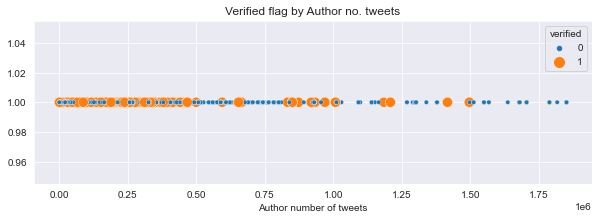

In [1136]:
fig,ax = plt.subplots(figsize = (10,3))
sns.scatterplot(x=master_df['user_tweet_count'],y=1,
                hue = master_df['verified'],
                size = master_df['verified'], sizes = (100,20))

ax.set(title = f'Verified flag by Author no. tweets', xlabel = 'Author number of tweets');

* No verified tweet author has >~1.5 M tweets.
* Taking verified as a subset sample of tweet users that we know are organic, real users, we can say that it is likely that if an author has >1.5M tweets it is likely they are non-organic, i.e. a bot

In [1137]:
# should attempt to filter out bots for fairer analysis
# removing rows with author > 1.5M tweets
master_df = master_df[master_df['user_tweet_count']<1500000]

* Seen that verifiability correlates with like count, but do users of similar number of followers but without verified status perform similarly?


In [1143]:
master_df['followers_count_banded_10'] =  pd.qcut(master_df['followers_count'],10, labels = [1,2,3,4,5,6,7,8,9,10])

# Split dataframe into verified and non verified users
verified_users_df = master_df[master_df['verified']=='1']
non_verified_users_df = master_df[master_df['verified']=='0']

In [1144]:
verified_analysis_df = pd.DataFrame()

verified_analysis_df['non_verified_followers'] = non_verified_users_df.groupby('followers_count_banded_10')['followers_count'].mean().values
verified_analysis_df['non_verified_count'] = non_verified_users_df.groupby('followers_count_banded_10')['followers_count'].count().values
verified_analysis_df['non_verified_likes'] = non_verified_users_df.groupby('followers_count_banded_10')['like_count'].mean().values

verified_analysis_df['verified_followers'] = verified_users_df.groupby('followers_count_banded_10')['followers_count'].mean().values
verified_analysis_df['verified_count'] = verified_users_df.groupby('followers_count_banded_10')['followers_count'].count().values
verified_analysis_df['verified_likes'] = verified_users_df.groupby('followers_count_banded_10')['like_count'].mean().values

verified_analysis_df

,non_verified_followers,non_verified_count,non_verified_likes,verified_followers,verified_count,verified_likes
0,5.699547,4633,0.701058,NaN,0,NaN
1,28.978835,4394,0.898270,NaN,0,NaN
2,68.390928,4277,1.660744,NaN,0,NaN
3,151.378082,4462,1.961900,150.000000,4,1.000000
4,272.822666,4359,2.267951,NaN,0,NaN
5,471.357208,4398,3.425421,442.166667,6,1.833333
6,816.880724,4586,4.006106,892.809524,21,4.428571
7,1522.993908,4104,5.190789,1428.086957,115,6.286957
8,3754.964867,4241,10.546805,4193.922727,220,11.163636
9,24977.725275,2730,25.830037,317009.359441,1647,42.101396


Just choose where followers_count_banded_10 is 5,6,7,8 - these have similar number followers in both categories

In [1146]:
verified_analysis_df = verified_analysis_df[(verified_analysis_df.index>=3) & (verified_analysis_df.index<9)]

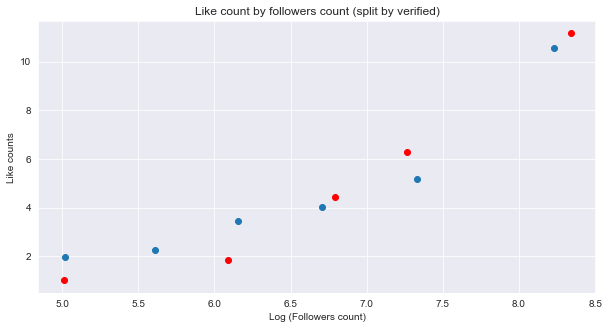

In [1149]:
fig,ax1 = plt.subplots(figsize = (10,5))
# ax2 = ax1.twinx()

ax1.scatter(x= np.log(verified_analysis_df['non_verified_followers']), y= verified_analysis_df['non_verified_likes'])
ax1.scatter(x= np.log(verified_analysis_df['verified_followers']), y= verified_analysis_df['verified_likes'], c = 'r')

ax1.set(title = f'Like count by followers count (split by verified)', xlabel = 'Log (Followers count)', ylabel = 'Like counts');

* Relationship of followers to likes is similar for both verified and non verified authors.
* (Worth noting there are not many verified authors in some of the buckets (see df cell above)
* Conclusion is that: verified status doe snot increase favourability of tweets


## Qu. 4.3: Behaviour analysis: Does hashtag in profile mean a tendency for user to put hashtag in recent tweets
* classification model
* is correlation lower if profile created date further away?

In [1164]:
master_df['profile_ht_tweet_ht'] = master_df['tweet_ht'] + "-" + master_df['profile_ht']


In [1175]:
profile_ht_tweet_ht = master_df.groupby(['profile_ht_tweet_ht'])['profile_ht_tweet_ht'].count()
ratio_without = profile_ht_tweet_ht['0-1'] / profile_ht_tweet_ht['0-0']
ratio_with = profile_ht_tweet_ht['1-1'] / profile_ht_tweet_ht['1-0']
ratio_with/ratio_without
print('Sample size: ', master_df.shape[0])
print('Given no ht in profile, ratio of ht in tweet:no ht in tweet: ', round(ratio_without,3))
print('Given ht in profile, ratio of ht in tweet:no ht in tweet: ', round(ratio_with,3))
print('Given ht in profile, increased probability of ht in tweet is: ', round(ratio_with/ratio_without,3))


Sample size:  44197
Given no ht in profile, ratio of ht in tweet:no ht in tweet:  0.129
Given ht in profile, ratio of ht in tweet:no ht in tweet:  0.211
Given ht in profile, increased probability of ht in tweet is:  1.643


In [1176]:
# Is this statistically significant?

[Text(0.5, 1.0, 'Mean like count by tweet_age_mins_banded'),
 Text(0.5, 0, 'tweet_age_mins_banded'),
 Text(0, 0.5, 'Like counts')]

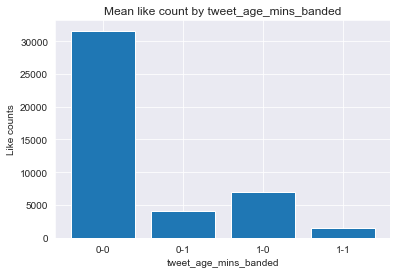

In [1165]:
fig,axes = plt.subplots()
items = list(master_df.groupby(['profile_ht_tweet_ht'])['profile_ht_tweet_ht'].count().index)
counts = list(master_df.groupby(['profile_ht_tweet_ht'])['profile_ht_tweet_ht'].count().values)

axes.bar(items, counts)

axes.set(title = f'Count of profile descriptions with hashtag that have ', xlabel = var, ylabel = 'Like counts')